#  Reccomendations: IBM Watson Studio 
---

PROJECT DESCRIPTION

## Table of Contents

In [70]:
#Import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import progressbar
from sklearn.metrics import accuracy_score

import project_tests.project_tests as t

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Import data
user_item_df = pd.read_csv('data/user-item-interactions.csv').drop(columns=['Unnamed: 0'])
content_df = pd.read_csv('data/articles_community.csv').drop(columns=['Unnamed: 0'])

## 1. Exploratory Data Analysis

DATA ANALYSIS DESCRTIPTION

In [3]:
content_df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
user_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
# Remove nulls from the data 
user_item_df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [6]:
# Drop nulls as we cannot identify the relevent customer email
user_item_dna_df = user_item_df.dropna() 

In [7]:
# Dont need to drop 
content_df.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

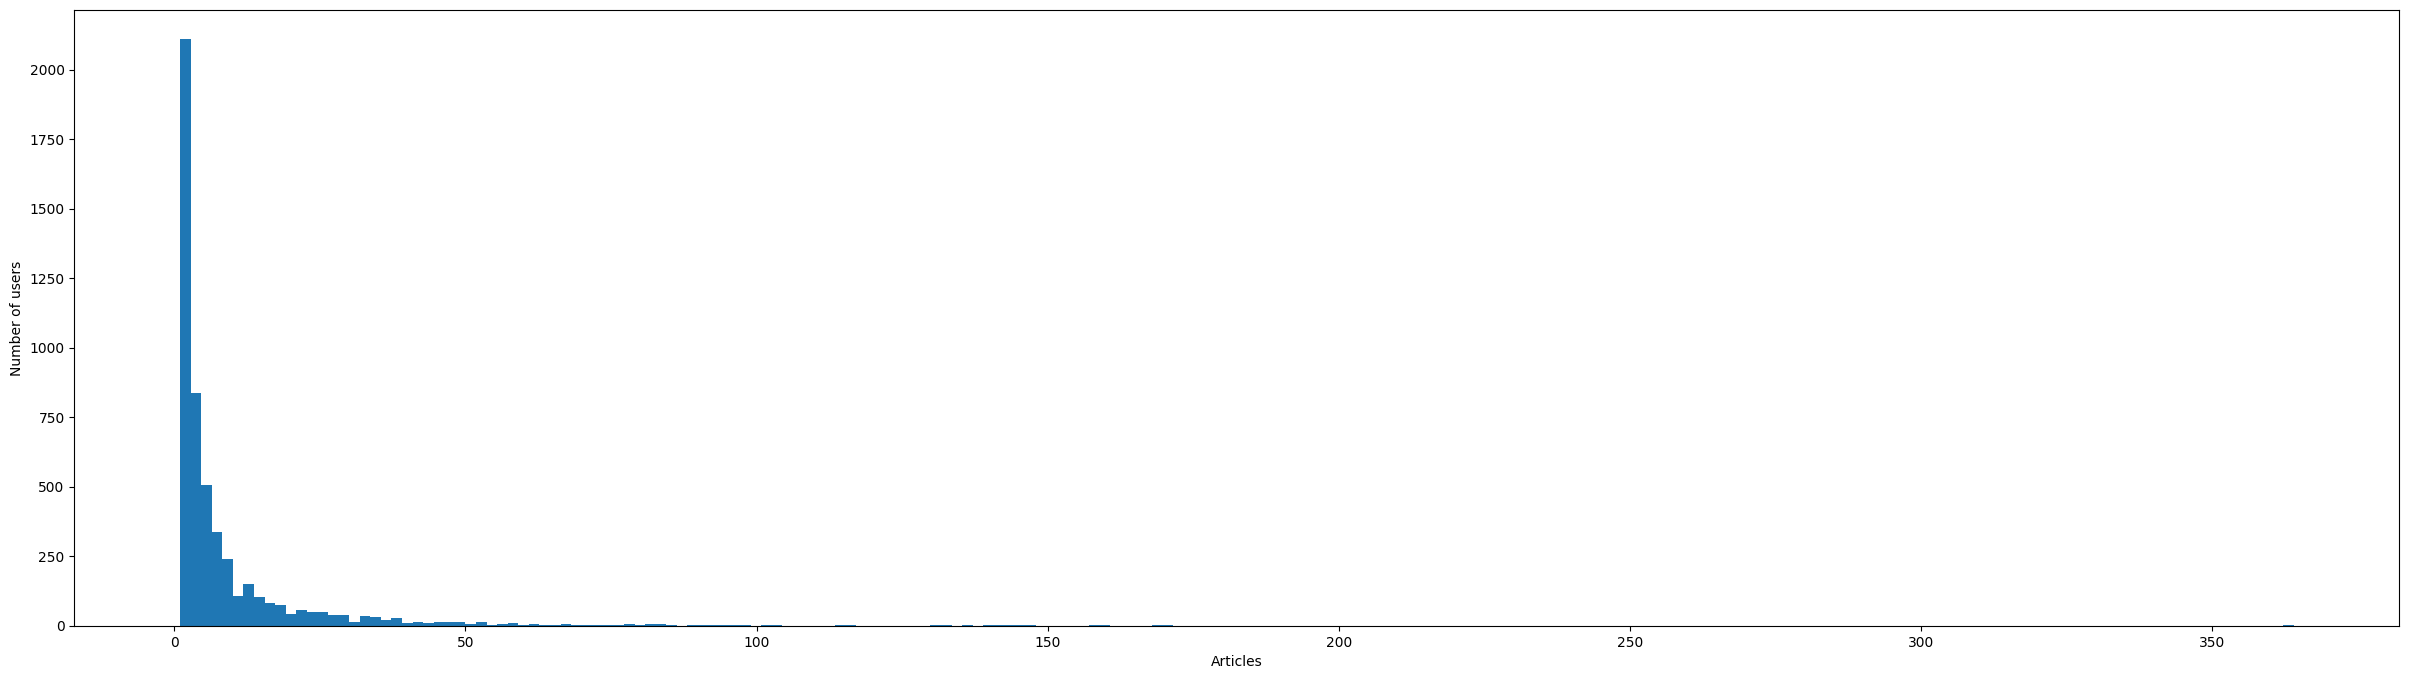

In [8]:
#Understand the distribution of articles read 
user_interactions_total_df = user_item_df.groupby('email').count()['article_id'].reset_index()

plt.figure(figsize=(30,8))
plt.hist(user_interactions_total_df['article_id'], bins=200);
plt.xlabel('Articles')
plt.ylabel('Number of users')
plt.show()

In [9]:
# Get the median valu for user to get the bottom 50% of interactions 
median_interactions = int(user_interactions_total_df['article_id'].median())

# Maximum user interaction 
maximum_articles_interaction = int(user_interactions_total_df['article_id'].max())

total_interactions = int(user_item_df.count()['article_id'])

# Most viewed article amount 

In [10]:
most_viewed = user_item_df.groupby('article_id').count().reset_index().sort_values('email',ascending= False)[0:1]

In [11]:
unique_articles = len(user_item_df['article_id'].unique())
unique_users = len(user_item_dna_df['email'].unique())## null value being taken out 
unique_articles_platform = len(content_df['article_id'].unique())

In [12]:
type(unique_articles)

int

In [13]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_interactions,
    '`The total number of user-article interactions in the dataset is ______.`': total_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': maximum_articles_interaction,
    '`The most viewed article in the dataset was viewed _____ times.`': most_viewed['email'].item(),
    '`The article_id of the most viewed article is ______.`': str(most_viewed['article_id'].item()),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': unique_articles_platform,
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


## 2. Rank-Based Recommendations

Rank based on number of times article is visitied by the same user as we don't have any other rating systems we can use

In [14]:
user_item_df[['article_id','email']]\
    .groupby(['email']).count()\
    .sort_values('article_id',ascending=False)\
    .reset_index()[:5]

,email,article_id
0,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
1,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
2,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
4,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


In [15]:
# Create function to get the top n articles 
def get_top_articles(n):
    '''
    Input
    n: number of top articles to return

    Output
    Returns a sorted list of the most viewed articles up to n amount 

    '''

    df = user_item_df

    top_df = df[['title','email']]\
                .groupby(['title']).count()\
                .sort_values('email',ascending=False)\
                .reset_index()[:n]

    top_articles_pre = top_df['title'].to_list()
    top_articles = [str(x) for x in top_articles_pre]

    

    return top_articles

In [16]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

In [17]:
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your to_20 looks like the solution list! Nice job.


## 3. User-User Based Collaborative Filtering

In [18]:
# add in customer id as email is very long 
unique_email_id = pd.DataFrame(user_item_df['email'].unique(),columns = ['email'])\
    .sort_values('email')\
    .reset_index(names = ['user_id'])

In [19]:
def email_mapper(df):
    '''
    Map the user email to a user_id column and remove the email column
    '''

    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])

    return email_encoded

email_encoded = email_mapper(user_item_df)
user_item_df['user_id'] = email_encoded

In [20]:
# Create matrix of binary 1's and 0's for articles customers have read 

def user_item_matrix_func(df):
    '''
    Input
    df: data frame or articles each user has interacted with at a user id level

    Output:
    A matrix of user id's and a binary flag for if they have interacted with an article
    '''

    user_item_matrix = user_item_df\
                        .groupby(['user_id', 'article_id'])['title']\
                        .agg(lambda x: 1).unstack()
    
    user_item_matrix.fillna(0,inplace = True)

    return user_item_matrix

user_item_matrix = user_item_matrix_func(user_item_df)

In [21]:
# Tests
assert user_item_matrix.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item_matrix.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item_matrix.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."

print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [22]:
np.array(user_item_matrix.loc[10]).reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [23]:
# First step of reccomendation is to find user similarity 
def find_similar_users(user_id, user_item_matrix = user_item_matrix):
    """
    Input
    user_id: The user we want to find the most similar users too
    user_item_matrix: Matrix of users and the articles they have veiwed 
    """

    # Use a sparse matrix to speep up comutation time 
    user_item_sparse = csr_matrix(user_item_matrix.values)

    user_index = user_item_matrix.index.get_loc(user_id)
    user_vector = user_item_sparse[user_index, :]
    matrix_no_user_id = user_item_sparse[np.arange(user_item_sparse.shape[0]) != user_index, :]
    similarity = matrix_no_user_id.dot(user_vector.T).toarray().flatten()

    similarity_df = pd.DataFrame({'user_id': user_item_matrix.index[np.arange(user_item_matrix.shape[0]) != user_index],
                                  'similarity': similarity}).sort_values('similarity', ascending=False)

    return list(similarity_df['user_id'])

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(
    find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(
    find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(
    find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 4459, 203, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [25]:
# Find the names of articles 
def get_article_names(article_ids,user_item_df=user_item_df):
    """
    Input:
    article_ids: a list or single value of article id's 
    user_item_df: User item data frame of articles users have veiwed 

    Output:
    List of distinct article name from the corresponding article id's 

    """

    if type(article_ids) == list:
        True
    else:
        article_ids = [article_ids]

    article_ids = [float(article_id) for article_id in article_ids]

    article_names = list(user_item_df[user_item_df['article_id'].isin(article_ids)]['title']\
                                .unique())
    
    return article_names

In [26]:
def get_user_articles(user_id, user_item_df=user_item_df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with
                    the list of article ids

    Description:
    Provides a list of the article_ids and article titles that have
    been seen by a user
    '''
    user_articles_df = user_item_df[user_item_df['user_id'] == user_id]
    article_ids = list(user_articles_df['article_id'].unique())
    article_ids = [str(article_id) for article_id in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names

In [27]:
def user_user_recs(user_id, m=5):
    # Find articles user has read 
    article_ids, _ = get_user_articles(user_id)
    # Find most similar users
    similar_users = find_similar_users(user_id)

    user_len = len(similar_users)
    rec_list = []

    i = 0 
    bar = progressbar.ProgressBar(maxval=user_len+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    for user in similar_users:
        i += 1
        bar.update(i)

        article_id_sim, _ = get_user_articles(user)

        # Check if the article has been seen or recommended
        not_seen = np.setdiff1d(np.array(article_id_sim), np.array(article_ids))
        not_reccomended = np.setdiff1d(not_seen, np.array(rec_list))
        

        # Add to the recommended list
        rec_list.extend(not_reccomended.tolist())

        # If there are more than m recommendations, break
        if len(rec_list) > m:
            break

    bar.finish()

    return rec_list[:m]


In [28]:
get_article_names(user_user_recs(1, 10))

[========================================================================] 100%


['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [29]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [30]:
def get_top_sorted_users(user_id, user_item_df = user_item_df, user_item_matrix = user_item_matrix):
    """
    Input
    user_id: The user we want to find the most similar users too
    user_item_matrix: Matrix of users and the articles they have veiwed 
    """

    # Use a sparse matrix to speep up comutation time 
    user_item_sparse = csr_matrix(user_item_matrix.values)

    user_index = user_item_matrix.index.get_loc(user_id)
    user_vector = user_item_sparse[user_index, :]
    matrix_no_user_id = user_item_sparse[np.arange(user_item_sparse.shape[0]) != user_index, :]
    similarity = matrix_no_user_id.dot(user_vector.T).toarray().flatten()

    similarity_df = pd.DataFrame({'similar_id': user_item_matrix.index[np.arange(user_item_matrix.shape[0]) != user_index],
                                  'similarity': similarity}).sort_values('similarity', ascending=False)
    
    tot_interact = user_item_df.groupby('user_id')['article_id'].count()
    tot_interact_df = pd.DataFrame({'similar_id': tot_interact.index,
                             'num_interactions': tot_interact.values})
    
    output_df = pd.merge(similarity_df,tot_interact_df, how = 'inner', on = 'similar_id')\
                    .sort_values(by=['similarity', 'num_interactions'], ascending = False)

    return output_df

def user_user_recs_part2(user_id, m=10):
    # Find articles user has read 
    article_ids, _ = get_user_articles(user_id)
    # Find most similar users
    similar_users = list(get_top_sorted_users(user_id)['similar_id'])

    user_len = len(similar_users)
    rec_list = []

    i = 0 
    bar = progressbar.ProgressBar(maxval=user_len+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    for user in similar_users:
        i += 1
        bar.update(i)

        article_id_sim, _ = get_user_articles(user)

        # Check if the article has been seen or recommended
        not_seen = np.setdiff1d(np.array(article_id_sim), np.array(article_ids))
        not_reccomended = np.setdiff1d(not_seen, np.array(rec_list))
        

        # Add to the recommended list
        rec_list.extend(not_reccomended.tolist())

        # If there are more than m recommendations, break
        if len(rec_list) > m:
            break

    bar.finish()

    rec_list = rec_list[:m]
    rec_names = get_article_names(rec_list)

    return rec_list,rec_names

In [31]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings']


In [32]:
# Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': int(get_top_sorted_users(1)['similar_id'].values[0]),
    'The user that is the 10th most similar to user 131': int(get_top_sorted_users(131)['similar_id'].values[9]),
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [33]:
new_user = '0.0'

# List of the top 10 article ids you would give to
new_user_recs = user_item_df[user_item_df['title'].isin(get_top_articles(10))]['article_id'].unique()
new_user_recs = [str(x) for x in new_user_recs]

In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


## 4. Collab filter based reccomendations 

We can use SVM with the article metric. Instead of which articles viewed we cna use number times to get a better view of rating 

In [87]:
def user_item_matrix_views_func(df):
    '''
    Input:
    df: DataFrame of articles each user has interacted with at a user id level

    Output:
    A matrix of user ids and the count of interactions with each article
    '''
    
    # Group by user_id and article_id, then count the interactions
    user_item_matrix = df.groupby(['user_id', 'article_id'])['title']\
                         .count().unstack().fillna(0)
    
    return user_item_matrix

user_items_views_matrix = user_item_matrix_views_func(user_item_df)

In [36]:
def get_item_based_recommendations(user_id,num_recommendations=5,  user_item_df = user_item_df ):

    user_item_matrix = user_item_df.groupby(['user_id', 'article_id'])['title']\
                         .count().unstack().fillna(0)
    
    sparse_user_item_matrix = csr_matrix(user_item_matrix.values)

    user_items_df = pd.DataFrame(sparse_user_item_matrix.toarray(), 
                                 index=user_item_matrix.index, 
                                 columns=user_item_matrix.columns)
    
    item_similarity = pd.DataFrame(cosine_similarity(user_items_df.T), 
                                   index=user_items_df.columns, 
                                   columns=user_items_df.columns)

    user_interactions = user_item_matrix.loc[user_id]
    interacted_items = user_interactions[user_interactions > 0].index.tolist()
    
    recommendations = pd.Series(dtype='float64')
    for item in interacted_items:
        similar_items = item_similarity.loc[item]
        recommendations = recommendations.add(similar_items, fill_value=0)
    
    recommendations = recommendations.drop(interacted_items)

    top_recommendations = recommendations.sort_values(ascending=False).head(num_recommendations).index.tolist()
    return top_recommendations

# Split the data
train_data, test_data = train_test_split(user_item_df, test_size=0.2, random_state=42)

# Generate recommendations for test users
test_user_ids = test_data['user_id'].unique()
recommendations = {user: get_item_based_recommendations(user)\
                    for user in [int(x) for x in test_user_ids]}

# Evaluate Precision@K and Recall@K
def precision_recall_at_k(recommendations, test_data, k=5):
    precisions = []
    recalls = []
    for user, recs in recommendations.items():
        true_items = test_data[test_data['user_id'] == user]['article_id'].tolist()
        top_k_recs = recs[:k]
        precision = len(set(top_k_recs) & set(true_items)) / k
        recall = len(set(top_k_recs) & set(true_items)) / len(true_items)
        precisions.append(precision)
        recalls.append(recall)
    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)

precision, recall = precision_recall_at_k(recommendations, test_data)
print(f'Precision@K: {precision}')
print(f'Recall@K: {recall}')

[1160.0, 1338.0, 1276.0, 1293.0, 43.0, 1351.0, 12.0, 1436.0, 1163.0, 1162.0]

Use SVD to speed up calculation to the factors that explain the most varaince 

In [88]:
u, s, vt = np.linalg.svd(user_items_views_matrix, full_matrices=False)

In [96]:
user_item_est.flatten()

array([1.46089661e-03, 8.04008911e-02, 2.00071545e-03, ...,
       1.08248358e-06, 1.77982273e-05, 1.56222336e-05])

Understand the number of latent factors needed 

In [97]:
num_latent_feats = []
accuracy = []

for i in range(1,len(s)):

    s_cut, u_cut, vt_cut = np.diag(s[:i]), u[:, :i], vt[:i, :]

    user_item_est = np.around(np.dot(np.dot(u_cut, s_cut), vt_cut))

    accuracy_pre = accuracy_score(user_items_views_matrix.to_numpy().flatten(), user_item_est.flatten())

    accuracy.append(accuracy_pre)
    num_latent_feats.append(i)

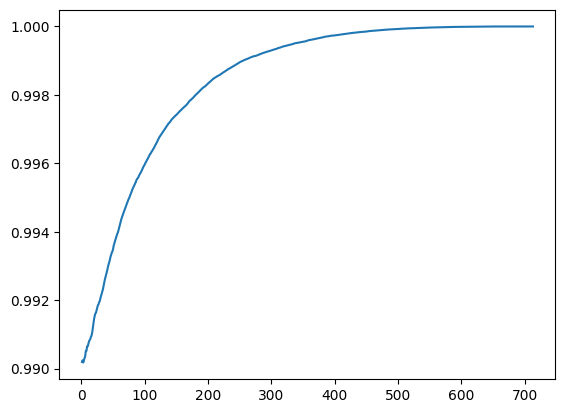

In [98]:
plt.plot(num_latent_feats,mse)

We can explain aroung 90% of the variance with only 163 factors 

Now we need to understand how this works when predicting new customer so split into jest and control 

In [116]:
df_train = user_item_df.head(40000)
df_test = user_item_df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    
    user_item_train = user_item_matrix_views_func(df_train)
    
    user_item_test = user_item_matrix_views_func(df_test)
    
    test_idx = list(user_item_train.index)  # test user ids
    test_art = list(user_item_train.columns)  # test article ids

    return user_item_train, user_item_test, test_idx, test_art


user_item_matrix_train, user_item_matrix_test, test_idx, test_art = create_test_and_train_user_item(df_train, df_test)

In [108]:
user_item_matrix_train.shape

(4487, 714)

In [118]:
user_item_matrix_test.shape[0]

682

In [122]:
user_item_matrix_test.shape[0] - len(np.setdiff1d(user_item_matrix_test.index, user_item_matrix_train.index))

20

In [124]:
len(np.setdiff1d(user_item_matrix_test.columns, user_item_matrix_train.columns))

0

In [125]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20
d = 0


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [ ]:
# Create svd of train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_matrix_train, full_matrices=False)

In [132]:
# user_id's that are in both test and train sets 
shared_user_id =  user_item_matrix_train.index[user_item_matrix_train.index.isin(test_idx)]

# get the boo
test_shared_row = user_item_matrix_test.index.isin(shared_user_id)
train_shared_row = user_item_matrix_train.index.isin(shared_user_id)

# Subset columns
train_columns_bool = user_item_matrix_train.columns.isin(test_art)

In [ ]:
num_latent_feats = []
accuracy = []

for i in range(1,len(s)):

    s_cut, u_cut, vt_cut = np.diag(s[:i]), u[:, :i], vt[:i, :]

    user_item_est = np.around(np.dot(np.dot(u_cut, s_cut), vt_cut))

    accuracy_pre = accuracy_score(user_items_views_matrix.to_numpy().flatten(), user_item_est.flatten())

    accuracy.append(accuracy_pre)
    num_latent_feats.append(i)

In [ ]:
acc_test,prec_test,rec_ttest = [],[],[]
acc_train,prec_train,rec_train = [],[],[]

for i in range(1,len(s_train)):
    s_train_cut, u_train_cut, vt_train_cut = np.diag(s_train[:i]), u_train[:, :i], vt_train[:i, :]

    user_item_train_est = np.around(np.dot(np.dot(u_train_cut, s_train_cut), vt_train_cut))

    # get common matracy subsets
    test_sub = user_item_matrix_test.to_numpy()[test_shared_row, :]
    train_sub = user_item_matrix_train.to_numpy()[train_shared_row][:, train_columns_bool]


    train_sub_flat = train_sub.flatten()
    train_sub_est_flat = train_sub_est.flatten()
    test_sub_flat = test_sub.flatten()
    test_sub_est_flat = test_sub_est.flatten()

    # Accurary
    acc_train.append(accuracy_score(train_sub_flat, train_sub_est_flat))
    acc_test.append(accuracy_score(test_sub_flat, test_sub_est_flat))
    # Precision 

    recall 



